In [1]:
import mahotas as mh
import numpy as np
import re
import os
import glob
import h5py
import pylab as plt
from tempfile import mkstemp
from pycmc import *
import tempfile
import shutil
import random
import abc
import sys
import cv2

from scipy.misc import imresize

from neuralimg.image import datasetconf as dc
from neuralimg.crag import crag_utils as cu

%matplotlib inline

class DatasetGen(object):

    __metaclass__ = abc.ABCMeta

    def __init__(self, config):
        # Read configuration file
        if not os.path.isfile(config):
            raise IOError('Config file not found')
        self.conf = dc.DatasetGenConf()
        self.conf.read(config)

    @abc.abstractmethod
    def _prepare_instances(self, crag, volumes, solution):
        """ Returns the set of instances depending on the subclass """

    def generate_instances(self, current_crag):
        """ Generates the data for the input crag dataset """
        print('Switching to CRAG {}'.format(current_crag))
        crag, volumes, solution, ebb, ein = cu.read_crag(current_crag)
        # Generate instances according to subclass
        total = self._prepare_instances(crag, volumes, solution)
        return total, crag, volumes, solution, ebb, ein

class PairDataGen(DatasetGen):

    def __init__(self, config):
        DatasetGen.__init__(self, config)

    def _prepare_instances(self, crag, volumes, solution):
        """ Splits assignment nodes into positive (if belong to CRAG solution)  and
         negative examples. If shuffle is True, examples are taken randomly from the
         CRAG (not in order). Pairs of node-label are returned """

        # Read assignment nodes
        nodes_positive = []
        nodes_negative = []
        # Gather positive and negative examples
        for n in crag.nodes():
            if crag.type(n) == CragNodeType.AssignmentNode:
                slices = cu.get_slices(crag, volumes, n)
                if solution.selected(n):
                    nodes_positive.append(slices)
                else:
                    nodes_negative.append(slices)

        # Add class label
        zipped_pos = zip(nodes_positive, [1] * len(nodes_positive))
        zipped_neg = zip(nodes_negative, [0] * len(nodes_negative))

        if self.conf.balance is True:
            zipped_pos, zipped_neg = balance_classes(zipped_pos, zipped_neg)

        print('Number of positive examples: {}'.format(len(zipped_pos)))
        print('Number of negative examples: {}'.format(len(zipped_neg)))

        return zipped_pos + zipped_neg
    
class TripletDataGen(DatasetGen):

    def __init__(self, config):
        DatasetGen.__init__(self, config)

    def _prepare_instances(self, crag, volumes, solution):
        """ For each assignment node from the solution, searches for
        an assignment node out of the solution that contains any of the slices
        connected to the first node """

        # Read assignment nodes
        instances = []
        for n in crag.nodes():
            if crag.type(n) == CragNodeType.AssignmentNode:

                if solution.selected(n):

                    # Get positive slices and negative possible slices
                    n1, n2 = cu.get_opposite(crag, n)
                    slice1, slice2 = [volumes.getVolume(i) for i in [n1, n2]]
                    neg_n1 = cu.get_nassigned_nodes(crag, volumes, solution, n1)

                    # Build instance only if a negative assignment for first has 
                    # been found. Among all, choose closets in space
                    if len(neg_n1) > 0:
                        third = get_closest(slice1, neg_n1)
                        # Build slices and add to set
                        instances.append([slice1, slice2, third])

        # Add label, though it is not used
        return zip(instances, )


def get_closest(ref, others):
    """ Retrieves node closests to the reference node according to L2 distance"""
    ref_center = get_center(ref)
    dists = [np.sqrt(sum((ref_center-get_center(i))**2)) for i in others]
    return others[dists.index(min(dists))]


def balance_classes(positive, negative):
    """ Balances positive and negative classes so the remaining data contains
    the same number of classes per each class """
    least = min(len(positive), len(negative))
    return positive[0:least], negative[0:least]


def get_center(vol):
    """ Computes the center of the bounding box """
    bb = vol.getBoundingBox()
    center = np.empty((2))
    for i in range(2):
        size = bb.max().__getitem__(i) - bb.min().__getitem__(i)
        center[i] = bb.min().__getitem__(i) + np.floor(size/2.0)
    return center

def plot_instance(slices, ebb, ein, imh, imw, padding, norm):
    """ Plots the input instance from the dataset """
    imgs = []
    tmpath = tempfile.mkdtemp()
    data = np.empty((len(slices), 3, imh, imw))
    
    # Obtain image matrix
    for i in range(len(slices)):
        data[i, ...] = get_imgs(slices[i], imh, imw, ein, ebb, norm, tmpath)
    
    # Plot images
    plot_matrix(data)
    
    # Plot metadata information
    prefixes = ['Reference image', 'Positive image', 'Negative image']
    prefixes = prefixes if len(slices) == 3 else ['Node'] * len(slices)
    for i in range(len(slices)):
        print_slice(prefixes[i], slices[i])
        
    shutil.rmtree(tmpath)
    return imgs, get_coordinates(slices)

def get_coordinates(sls):
    """ Return bounding box limits and section for each input slice """
    coords = []
    for sl in sls:
        bb = sl.getBoundingBox()
        coords.append([bb.min().x(), bb.min().y(), bb.max().x(), bb.max().y(), bb.min().z()])
    return coords

def print_slice(prefix, sl):
    bb = sl.getBoundingBox()
    print(prefix + ':' + 'from (%d, %d) to (%d, %d) in section %d' 
          % (bb.min().x(), bb.min().y(), bb.max().x(), bb.max().y(), bb.min().z()))

def plot_matrix(data):
    """ Plots each slice in a row and each channel in a column """
    instances, channels = data.shape[0], data.shape[1]
    print('Instances %d' % instances)
    print('Channels %d' % channels)
    f, axarr = plt.subplots(instances, channels, sharex=True, sharey=True,
                           figsize=(10, 7))
    if instances == 1:
        for j in range(channels):
            axarr[j].imshow(data[0, j, ...])
    else:
        for i in range(instances):
            for j in range(channels):
                axarr[i, j].imshow(data[i, j, ...])

def print_nodes(volumes, nodes, ebb, ein, imh, imw, padding, norm):
    """ Prints the input nodes in a grid """
    slices = [volumes.getVolume(i) for i in nodes]
    plot_instance(slices, ebb, ein, imh, imw, padding, norm)
            
def get_imgs(sl, imh, imw, ein, ebb, norm, tmpath):
    """ Returns the images corresponding to the input slice for 3 channels """
    mat = np.empty((3, imh, imw))
    # Pad and resize bounding boxes
    bb = cu.compute_bbs([sl], padding, imh, imw, ein)[0]
    # Binary image
    ev = CragVolume()
    mat[0, :, :] = get_slice(sl, bb, ev, tmpath, imh, imw, norm, True)
    # Raw image
    ev = ExplicitVolume_f()
    mat[1, :, :] = get_slice(ein, bb, ev, tmpath, imh, imw, norm, False)
    # Membrane image
    ev = ExplicitVolume_f()
    mat[2, :, :] = get_slice(ebb, bb, ev, tmpath, imh, imw, norm, False)
    return mat
    
def get_slice(sl, bb, ev, tmpath, imh, imw, norm, binary):
    """ Returns image for the input slice and volume """
    src_bb = sl.getBoundingBox() if binary is True else None
    im_slice = cu.get_resized_slice(sl, bb, ev, tmpath, imh, imw, norm, src_bb)
    return im_slice

Instances 3
Channels 3


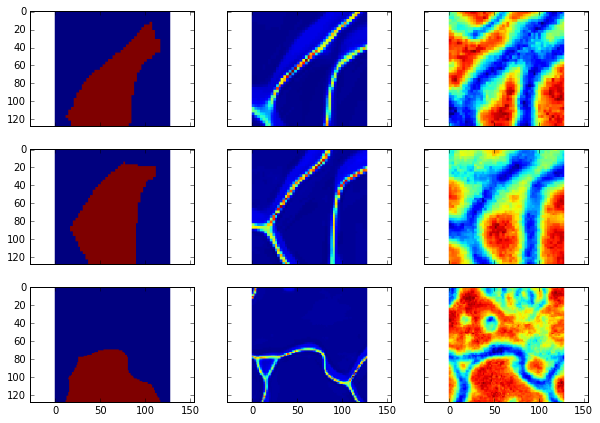

In [12]:
instance_num = 47413
a = h5py.File('/DataDisk/morad/cremi/datasets/dataA.h5')
d = a['data'][instance_num]
plot_matrix(d)

Instances 3
Channels 3


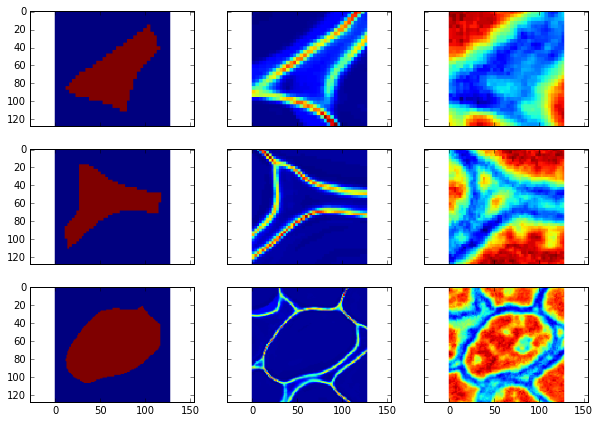

In [2]:
# Load all instances, may take a while ...
data_path = '/DataDisk/morad/cremi/crags/sampleA/mc_heuristic/hdf/training_dataset.h5'
d = TripletDataGen('/home/morad/projects/neural/neuralimg/image/config/data.conf')
instances, crag, volumes, solution, ebb, ein = d.generate_instances(data_path)

Switching to CRAG /DataDisk/morad/cremi/crags/sampleA/mc_heuristic/hdf/training_dataset.h5


Reference image:from (511, 713) to (626, 792) in section 7
Positive image:from (611, 740) to (612, 749) in section 8
Negative image:from (462, 656) to (542, 830) in section 8


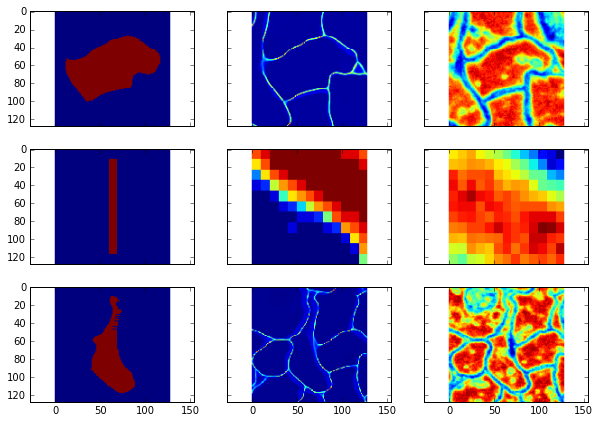

In [92]:
imh, imw = 128, 128
padding = 1.20
norm = True
row = np.random.randint(len(instances))
print('Instance %d' % row) # Example with row 102977
slices = instances[row][0]
ims, coords = plot_instance(slices, ebb, ein, imh, imw, padding, norm)

In [155]:
# Search functions

def node_from_coords(crag, volumes, coords):
    """ Search node given exact coordinates """
    minx, miny, maxx, maxy, section = coords
    nodes = crag.nodes()
    for n in nodes:
        if crag.type(n) == CragNodeType.SliceNode:
            bb = volumes.getVolume(n).getBoundingBox()
            if bb.min().x() == minx and bb.min().y() == miny and \
                bb.max().x() == maxx and bb.max().y() == maxy and \
                bb.min().z() == section:
                return n
    return None

def get_section(volumes, node):
    """ Returns the section a node belongs to """
    return volumes.getVolume(node).getBoundingBox().min().z()

def get_opposite(crag, volumes, ref, assign, forward):
    """ Returns nodes connected with reference one through the assignment
    nodes from the input according to specified direction """
    res = []
    z_ref = get_section(volumes, ref)
    for a in assign:
        adj = crag.adjEdges(a)
        ops = [crag.oppositeNode(a, e) for e in adj]
        ops_no_ref = [i for i in ops if crag.id(i) != crag.id(ref)]
        up = [i for i in ops_no_ref if get_section(volumes, i) > z_ref]
        down = [i for i in ops_no_ref if get_section(volumes, i) < z_ref]
        res = res + up if forward == True else res + down
    return res

def get_connected(node, crag, volumes, solutions, sol=True, forward=True):
    """ Returns the nodes connected with the input node through assignment nodes.
    Can specify if we only want forward connections or backwards (forward=False). 
    If sol is True, we only consider connections that are part of the best effort """
    adj = crag.adjEdges(node)
    opposite = [crag.oppositeNode(node, e) for e in adj]
    an = [i for i in opposite if crag.type(i) == CragNodeType.AssignmentNode] # Get only adjacent assignment nodes
    print('Num an %d' % len(an))
    # Get only those from solution if requested
    selected = [a for a in an if solution.selected(a) is True]
    an = selected if sol is True else an
    # Get desired direction
    return get_opposite(crag, volumes, node, an, forward)

def get_instance(instances, volumes, node, position=1):
    """ Get instances that contain the input node in the given positions:
    0 -> reference (z), 1-> positive (z+1), 2-> negative (z+1)"""
    res = []
    for i in instances:
        slices = i[0]
        if is_same_volume(slices[position], volumes.getVolume(node)):
            res.append(i)
    return res

def is_same_volume(vol1, vol2):
    bb1 = vol1.getBoundingBox()
    bb2 = vol2.getBoundingBox()
    return bb1.min().x() == bb2.min().x() and bb1.min().y() == bb2.min().y() and \
        bb1.max().x() == bb2.max().x() and bb1.max().y() == bb2.max().y() and \
        bb1.min().z() == bb2.min().z()
    

Instances 2
Channels 3
Node:from (509, 715) to (627, 795) in section 8
Node:from (611, 740) to (612, 749) in section 8


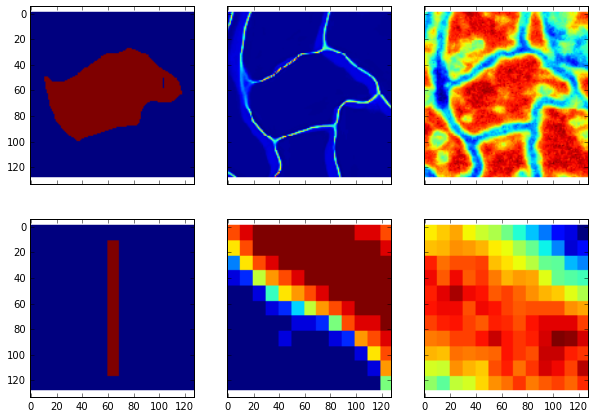

In [131]:
# Get nodes the reference one is connected in the next section
n = node_from_coords(crag, volumes, coords[0])
others = get_connected(n, crag, volumes, solution, sol=True, forward=True)
print_nodes(volumes, others, ebb, ein, imh, imw, padding, norm)

Instances 3
Channels 3
Reference image:from (511, 713) to (626, 792) in section 7
Positive image:from (509, 715) to (627, 795) in section 8
Negative image:from (462, 656) to (542, 830) in section 8


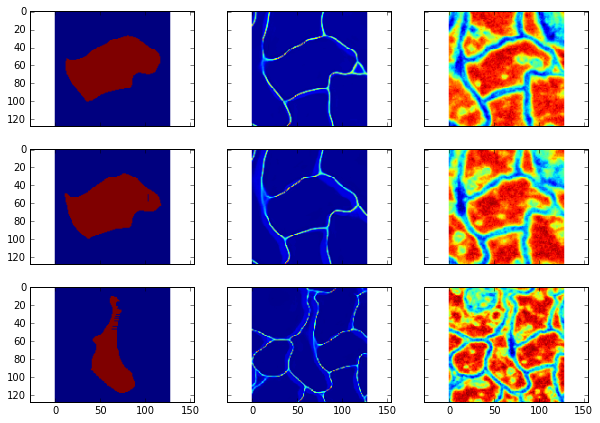

In [164]:
# Search instance that has the second slice
n2 = node_from_coords(crag, volumes, [509.0, 715.0, 627.0, 795.0, 8.0])
#print_nodes(volumes, [n2], ebb, ein, imh, imw, padding, norm)
inst = get_instance(instances, volumes, n2, position=1)
ims2, coords2 = plot_instance(inst[0][0], ebb, ein, imh, imw, padding, norm)
#others2 = get_connected(n2, crag, volumes, solution, sol=True, forward=True)
#print_nodes(volumes, others2, ebb, ein, imh, imw, padding, norm)